# Testing against ED - Hubbard on a ring

In this example we use the [pyALF](https://git.physik.uni-wuerzburg.de/ALF/pyALF/-/tree/ALF-2.2) interface to run ALF with the Mz choice of Hubbard Stratonovitch  transformation on a four site ring, at $U/t=4$  and inverse temperature $\beta t = 2$.  For this set of parameters, the exact  internal energy reads:   
$$
 \left\langle -t \sum_{\langle i,j\rangle, \sigma} \hat{c}_{i,\sigma}^{\dagger} \hat{c}_{j,\sigma}^{\phantom\dagger}   +  U  \sum_{i=1}^{N} \hat{n}_{i,\uparrow}\hat{n}_{j,\downarrow}  \right\rangle  =   -1.47261997 t 
$$
 
To reproduce this result we will have to carry out a systematic $\Delta \tau t$ extrapolation keeping $\Delta \tau t L_\text{Trotter} = 2$  constant.   
Recall that  the formulation of the auxiliary field QMC approach is based on the Trotter decomposition 
$$
e^{ -\Delta \tau \left( \hat{A} + \hat{B} \right) }  =  e^{ -\Delta \tau \hat{A}/2}  e^{ -\Delta \tau  \hat{B}  }   e^{ -\Delta \tau \hat{A}/2}  +  \mathcal{O} \left (\Delta  \tau^3\right)
$$
The overall error produced by this approximation is of the order $\Delta \tau^2$.  

Bellow we go through the steps for performing this extrapolation: setting the simulation parameters, running it and analyzing the data.

---

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as mathematics and plotting packages:

In [1]:
import os
from py_alf import Simulation            # Interface with ALF
# 
import numpy as np                       # Numerical library
from scipy.optimize import curve_fit     # Numerical library
import matplotlib.pyplot as plt          # Plotting library

**2.** Create instances of `Simulation`, specifying the necessary parameters, in particular the different $\Delta \tau$ values:

In [2]:
sims = []                                # Vector of Simulation instances
print('dtau values used:')
for dtau in [0.05, 0.1, 0.2]:            # Values of dtau
    print(dtau)
    sim = Simulation(
        'Hubbard',                       # Hamiltonian
        {                                # Model and simulation parameters for each Simulation instance
        'Lattice_type': 'N_leg_ladder',  #    Lattice type
        'L1': 4,                         #    Lattice length in the first unit vector direction
        'L2': 1,                         #    Lattice length in the second unit vector direction
        'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
        'Symm': True,                    #    Whether symmetrization takes place
        'ham_T': 1.0,                    #    Hopping parameter
        'ham_U': 4.0,                    #    Hubbard interaction
        'ham_Tperp': 0.0,                #    For bilayer systems
        'beta': 2.0,                     #    Inverse temperature
        'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
        'NSweep': 500,                   #    Number of sweeps per bin
        'NBin': 50,                      #    Number of bins
        'Dtau': dtau,                    #    Only dtau varies between simulations, Ltrot=beta/Dtau
        'Mz': True,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
        },                               #             HS field couples to z-component of magnetization
        branch='ALF-2.2',                      # ALF version
        alf_dir=os.getenv('ALF_DIR', './ALF'), # Directory with ALF source code. Gets it from 
                                               # environment variable ALF_DIR, if present
    )
    sims.append(sim)

dtau values used:
0.05
0.1
0.2


**3.** Compile ALF, downloading it first if not found locally. This may take a few minutes:

In [3]:
sims[0].compile()                        # Compilation needs to be performed only once

Checking out branch ALF-2.2
Compiling ALF... Done.


**4.** Perform the simulations, as specified in each element of `sim`:

In [4]:
for i, sim in enumerate(sims):
    sim.run()                            # Perform the actual simulation in ALF

Prepare directory "/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.05_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.1_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF/Prog/ALF.out
Prepare directory "/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.2_Mz=True" for Monte Carlo run.
Create new directory.
Run /home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF/Prog/ALF.out


**5.** Calculate the internal energies:

In [5]:
ener = np.empty((len(sims), 2))          # Matrix for storing energy values
dtaus = np.empty((len(sims),))           # Matrix for Dtau values, for plotting
for i, sim in enumerate(sims):
    print(sim.sim_dir)                   # Directory containing the simulation output
    sim.analysis()                       # Perform default analysis
    dtaus[i] = sim.sim_dict['Dtau']                             # Store Dtau value
    ener[i] = sim.get_obs(['Ener_scalJ'])['Ener_scalJ']['obs']  # Store internal energy

/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.05_Mz=True
Analysing Pot_scal
Analysing Part_scal
Analysing Kin_scal
Analysing Ener_scal
Analysing SpinT_eq
Analysing Den_eq
Analysing Green_eq
Analysing SpinZ_eq
Analysing SpinXY_eq
/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.05_Mz=True/Ener_scalJ 1
/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Dtau=0.1_Mz=True
Analysing Pot_scal
Analysing Part_scal
Analysing Kin_scal
Analysing Ener_scal
Analysing SpinT_eq
Analysing Den_eq
Analysing Green_eq
Analysing SpinZ_eq
Analysing SpinXY_eq
/home/stafusa/Jobs/Uni-Wuerzburg/ALF/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4

In [6]:
print('For Dtau values', dtaus, 'the measured energies are:\n', ener)

For Dtau values [0.05 0.1  0.2 ] the measured energies are:
 [[-1.47271744  0.0042683 ]
 [-1.47793129  0.00524019]
 [-1.48789014  0.00474862]]


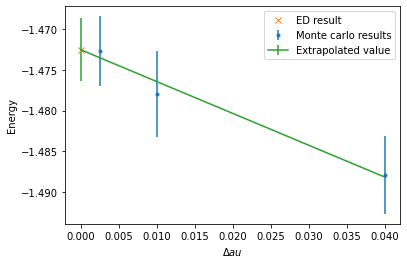

In [7]:
plt.figure()
plt.xlabel('$\Delta\tau$')
plt.ylabel('Energy')
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1], fmt='.', label="Monte carlo results")
plt.plot(0, -1.47261997, 'x', label='ED result')

def func(x, y0, a):
    return y0 + a*x**2
popt, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
xs = np.linspace(0., dtaus.max())
p = plt.plot(xs**2, func(xs, *popt))

plt.errorbar(0, popt[0], perr[0], label="Extrapolated value", color=p[0].get_color())
plt.legend()

---
## Exercises
1. Redo the extrapolation for different values of $\beta t$ (e.g., for $\beta t =$ 1, the internal energy is -0.62186692$t$, and for $\beta t =$ 4, it is -1.90837196$t$).
2. Experiment with different settings for `Checkerboard` and `Symm`.